# Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from torch_geometric.data import Data, InMemoryDataset, download_url, Batch
import torch_geometric.transforms as T
from dgl.data.utils import Subset, load_graphs
from torch_geometric.utils import k_hop_subgraph
import torch
import torch_geometric
import pdb
#from torch_geometric.data import Data, DataLoader
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout, ELU, GELU
from torch_geometric.nn import GINConv, GINEConv, WLConv, GATv2Conv
import torch.optim as optim
from torch_geometric.nn import global_mean_pool, global_add_pool, global_max_pool
warnings.filterwarnings('ignore')
from tqdm import tqdm
import torch.utils.data
from torch.utils.data.dataloader import default_collate
from torch_geometric.utils import degree
from torch_geometric.data import Data
import collections.abc as container_abcs
from scipy.special import comb

# Dataset Creation

In [4]:
class Dataset_1_orig(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(Dataset_1_orig, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['dataset1_orig.pt']

    def download(self):
        pass

    def count_2star(self, data):
        egde_index, num_nodes = data.edge_index, data.num_nodes
        k = torch.tensor([], dtype=torch.long)
        for ind in range(num_nodes):
            nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
            ind, 1, egde_index, False, num_nodes)
            edge_index_ = edge_index_.T
            mask = (edge_index_ == ind).all(dim=1)
            edge_index_ = edge_index_[mask].T
            k = torch.cat((k,torch.tensor([comb(nodes_.shape[0]-1,2, exact=True)])), dim=0)
        return torch.sum(k)

    def count_chordal(self, data):
        edge_index, num_nodes = data.edge_index, data.num_nodes
        total_edge_index = torch.tensor([], dtype=torch.long)
        l = torch.tensor([], dtype=torch.long)
        for ind in range(num_nodes):
            nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
            ind, 1, edge_index, False, num_nodes)
            edge_index_ = edge_index_.T
            mask = (edge_index_ != ind).all(dim=1)
            edge_index_ = edge_index_[mask].T
            total_edge_index = torch.cat((total_edge_index, edge_index_.T), dim=0)
            nodes_ = nodes_[nodes_ != ind]
            deg = degree(edge_index_[0], num_nodes)
            ll = sum([comb(i, 2, exact=True) for i in  deg[deg > 1]])
            l = torch.cat((l, torch.tensor([ll])), dim=0)
        return torch.sum(l)//2
    
    def countC4(self, data):
        edge_index, num_nodes = data.edge_index, data.num_nodes
        l = torch.tensor([], dtype=torch.long)
        for ind in range(num_nodes):
            node_dict = {}
            nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
            ind, 2, edge_index, False, num_nodes)
            edge_index_ = edge_index_.T
            nodes_ = nodes_[nodes_ != ind]
            edge_list = edge_index_.tolist()
            node_dict = {n.item(): 1 if [ind, n] in edge_list or [n, ind] in edge_list else 0 for n in nodes_}
            mask = (edge_index_ != ind).all(dim=1)
            edge_index_ = edge_index_[mask].T
            ll = 0
            edge_list = edge_index_.T.tolist()

            for n in node_dict:
                nei = sum([1 for m in node_dict if [n, m] in edge_list and [m, n] in edge_list and node_dict[m] == 1])
                if nei >= 2:
                    ll += comb(nei, 2, exact=True)
                    
            l = torch.cat((l, torch.tensor([ll])), dim=0)
       
        
        return torch.ceil(torch.sum(l)/4)
    
    def from_dgl(self, g, star, tri, tail_tri, attr_tri, chord):
        import dgl

        from torch_geometric.data import Data, HeteroData

        if not isinstance(g, dgl.DGLGraph):
            raise ValueError(f"Invalid data type (got '{type(g)}')")

       
        data = Data()
        data.edge_index = torch.stack(g.edges(), dim=0)

        for attr, value in g.ndata.items():
            data[attr] = value
        for attr, value in g.edata.items():
            data[attr] = value

        data.C4 = self.countC4(data)
        data.star = star.item()
        data.triangle = tri.item()
        data.tailed_triangle = tail_tri.item()
        data.attributed_triangle = attr_tri.item()
        data.chordal_cycle = self.count_chordal(data)
        data.star_2 = self.count_2star(data)
        return data

    def process(self):
        glist, all_labels = load_graphs("/hdfs1/Data/Shubhajit/WL_Substructure_Counting/data/dataset1.bin")
        data_list = []
        for i in zip(glist, all_labels["star"], all_labels["triangle"], all_labels["tailed_triangle"], all_labels["attributed_triangle"], all_labels["chordal_cycle"]):
            data = self.from_dgl(i[0], i[1], i[2], i[3], i[4], i[5])
            data_list.append(data)

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

class Dataset_2_orig(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(Dataset_2_orig, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['dataset2_orig.pt']

    def download(self):
        pass

    def count_triangle(self, data):
        edge_index, num_nodes = data.edge_index, data.num_nodes
        if num_nodes > 0:
            node_name = torch.unique(edge_index[0])
        else:
            return 0
        num_edges = 0
        for ind in node_name:
            nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
            ind.item(), 1, edge_index, False, num_nodes)
            edge_attr_ = None
            edge_index_ = edge_index_.T
            mask = (edge_index_ != ind).all(dim=1)
            edge_index_ = edge_index_[mask].T
            num_edges += edge_index_.shape[1]
        return torch.tensor([num_edges//6]) 

    def count_K4(self, data):
        edge_index, num_nodes = data.edge_index, data.num_nodes
        total_edge_index = torch.tensor([], dtype=torch.long)
        l = torch.tensor([], dtype=torch.long)
        for ind in range(num_nodes):
            nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
            ind, 2, edge_index, False, num_nodes)
            edge_index_ = edge_index_.T
            mask = (edge_index_ != ind).all(dim=1)
            edge_index_ = edge_index_[mask].T
            data_ = Data(edge_index=edge_index_, z=z_)
            l = torch.cat((l, self.count_triangle(data_)), dim=0)

        return torch.sum(l)//4

    def count_2star(self, data):
        egde_index, num_nodes = data.edge_index, data.num_nodes
        k = torch.tensor([], dtype=torch.long)
        for ind in range(num_nodes):
            nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
            ind, 1, egde_index, False, num_nodes)
            edge_index_ = edge_index_.T
            mask = (edge_index_ == ind).all(dim=1)
            edge_index_ = edge_index_[mask].T
            k = torch.cat((k,torch.tensor([comb(nodes_.shape[0]-1,2, exact=True)])), dim=0)
        return torch.sum(k)

    def count_chordal(self, data):
        edge_index, num_nodes = data.edge_index, data.num_nodes
        total_edge_index = torch.tensor([], dtype=torch.long)
        l = torch.tensor([], dtype=torch.long)
        for ind in range(num_nodes):
            nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
            ind, 1, edge_index, False, num_nodes)
            edge_index_ = edge_index_.T
            mask = (edge_index_ != ind).all(dim=1)
            edge_index_ = edge_index_[mask].T
            total_edge_index = torch.cat((total_edge_index, edge_index_.T), dim=0)
            nodes_ = nodes_[nodes_ != ind]
            deg = degree(edge_index_[0], num_nodes)
            ll = sum([comb(i, 2, exact=True) for i in  deg[deg > 1]])
            l = torch.cat((l, torch.tensor([ll])), dim=0)
        return torch.sum(l)//2

    def countC4(self, data):
        edge_index, num_nodes = data.edge_index, data.num_nodes
        l = torch.tensor([], dtype=torch.long)
        for ind in range(num_nodes):
            node_dict = {}
            nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
            ind, 2, edge_index, False, num_nodes)
            edge_index_ = edge_index_.T
            nodes_ = nodes_[nodes_ != ind]
            edge_list = edge_index_.tolist()
            node_dict = {n.item(): 1 if [ind, n] in edge_list or [n, ind] in edge_list else 0 for n in nodes_}
            mask = (edge_index_ != ind).all(dim=1)
            edge_index_ = edge_index_[mask].T
            ll = 0
            edge_list = edge_index_.T.tolist()

            for n in node_dict:
                nei = sum([1 for m in node_dict if [n, m] in edge_list and [m, n] in edge_list and node_dict[m] == 1])
                if nei >= 2:
                    ll += comb(nei, 2, exact=True)
                    
            l = torch.cat((l, torch.tensor([ll])), dim=0)
       
        
        return torch.ceil(torch.sum(l)/4)

    def from_dgl(self, g, star, tri, tail_tri, attr_tri, chord):
        import dgl

        from torch_geometric.data import Data, HeteroData

        if not isinstance(g, dgl.DGLGraph):
            raise ValueError(f"Invalid data type (got '{type(g)}')")

        
        data = Data()
        data.edge_index = torch.stack(g.edges(), dim=0)

        for attr, value in g.ndata.items():
            data[attr] = value
        for attr, value in g.edata.items():
            data[attr] = value

        data.C4 = self.countC4(data)
        data.star = star.item()
        data.triangle = tri.item()
        data.tailed_triangle = tail_tri.item()
        data.attributed_triangle = attr_tri.item()
        data.chordal_cycle = self.count_chordal(data)
        data.star_2 = self.count_2star(data)

        return data

    def process(self):
        glist, all_labels = load_graphs("/hdfs1/Data/Shubhajit/WL_Substructure_Counting/data/dataset2.bin")
        data_list = []
        for i in zip(glist, all_labels["star"], all_labels["triangle"], all_labels["tailed_triangle"], all_labels["attributed_triangle"], all_labels["chordal_cycle"]):
            data = self.from_dgl(i[0], i[1], i[2], i[3], i[4], i[5])
            data_list.append(data)

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

# Helper

In [89]:
import torch
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.data import Data
from scipy.special import comb
from torch_geometric.utils import degree

class collater():
    def __init__(self, task):
        self.task = task
        pass

    def create_subgraphs(self, data):

        edge_index, num_nodes = data.edge_index, data.num_nodes
        
        num_edges = 0
        subgraphs = {}
        total_edge_index = torch.tensor([], dtype=torch.long)
        l = torch.tensor([], dtype=torch.long)
        k = torch.tensor([], dtype=torch.long)
        for ind in range(num_nodes):
            if self.task == "triangle":
                nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
                ind, 1, edge_index, False, num_nodes)
                edge_attr_ = None
                edge_index_ = edge_index_.T
                mask = (edge_index_ != ind).all(dim=1)
                edge_index_ = edge_index_[mask].T
                total_edge_index = torch.cat((total_edge_index, edge_index_.T), dim=0)
                data_ = Data(edge_index=edge_index_, z=z_)
                l = torch.cat((l,torch.tensor([edge_index_.shape[1]//2])), dim=0)
                num_edges += edge_index_.shape[1]
                
            elif self.task == "3star":
                nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
                ind, 1, edge_index, False, num_nodes)
                edge_attr_ = None
                edge_index_ = edge_index_.T

                mask = (edge_index_ == ind).all(dim=1)
                edge_index_ = edge_index_[mask].T
                total_edge_index = torch.cat((total_edge_index, edge_index_.T), dim=0)
                data_ = Data(edge_index=edge_index_, z=z_)
                #l = torch.cat((l, torch.tensor([nodes_.shape[0]-1])), dim=0)
                l = torch.cat((l,torch.tensor([edge_index_.shape[1]//2])), dim=0)
                #k = torch.cat((k,torch.tensor([comb(nodes_.shape[0]-1,3, exact=True)])), dim=0)
                k = torch.cat((k,torch.tensor([comb(edge_index_.shape[1]//2,3, exact=True)])), dim=0)
            
            elif self.task == "C4":
                node_dict = {}
                nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
                ind, 2, edge_index, False, num_nodes)
                edge_index_ = edge_index_.T
                nodes_ = nodes_[nodes_ != ind]
                edge_list = edge_index_.tolist()
                node_dict = {n.item(): 1 if [ind, n] in edge_list or [n, ind] in edge_list else 2 for n in nodes_}
                mask = (edge_index_ != ind).all(dim=1)
                edge_index_ = edge_index_[mask].T
                total_edge_index = torch.cat((total_edge_index, edge_index_.T), dim=0)
                x = torch.ones([num_nodes, 1]).to(edge_index.device)
                for n in node_dict:
                    nei_num = 0
                    for m in node_dict:
                        if node_dict[m] == 1 and [n, m] in edge_list and [m, n] in edge_list:
                            nei_num += 1
                    x[n] = torch.tensor([nei_num])
                
                data_ = Data(edge_index=edge_index_, z=z_)
                ll = 0
                edge_list = edge_index_.T.tolist()
                total_nei = 0
                for n in node_dict:
                    nei = sum([1 for m in node_dict if [n, m] in edge_list and [m, n] in edge_list and node_dict[m] == 1])
                    if nei >= 2:
                        total_nei = total_nei + nei
                        ll += comb(nei, 2, exact=True)
                        
                l = torch.cat((l, torch.tensor([ll])), dim=0)
                k = torch.cat((k, torch.tensor([ll])), dim=0)

            elif self.task == "chordal":
                nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
                ind, 1, edge_index, False, num_nodes)
                edge_attr_ = None
                edge_index_ = edge_index_.T
                mask = (edge_index_ != ind).all(dim=1)
                edge_index_ = edge_index_[mask].T
                total_edge_index = torch.cat((total_edge_index, edge_index_.T), dim=0)
                data_ = Data(edge_index=edge_index_, z=z_)
                nodes_ = nodes_[nodes_ != ind]
                deg = degree(edge_index_[0], num_nodes)
                ll = sum([comb(i, 2, exact=True) for i in deg[deg > 1]])
                l = torch.cat((l, torch.tensor([ll])), dim=0)
                k = torch.cat((k, torch.tensor([ll])), dim=0)

            elif self.task == "2star":
                nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
                ind, 1, edge_index, False, num_nodes)
                edge_index_ = edge_index_.T
                mask = (edge_index_ == ind).all(dim=1)
                edge_index_ = edge_index_[mask].T
                data_ = Data(edge_index=edge_index_, z=z_)
                #k = torch.cat((k,torch.tensor([comb(nodes_.shape[0]-1,2, exact=True)])), dim=0)
                #l = torch.cat((l, torch.tensor([nodes_.shape[0]-1])), dim=0)
                k = torch.cat((k,torch.tensor([comb(edge_index_.shape[1]//2,2, exact=True)])), dim=0)
                l = torch.cat((l,torch.tensor([edge_index_.shape[1]//2])), dim=0)

            elif self.task == "local_nodes":
                nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
                ind, 1, edge_index, False, num_nodes)
                edge_index_ = edge_index_.T
                mask = (edge_index_ == ind).all(dim=1)
                edge_index_ = edge_index_[mask].T
                data_ = Data(edge_index=edge_index_, z=z_)
                k = torch.cat((k,torch.tensor([edge_index_.shape[1]//2])), dim=0)
                l = torch.cat((l,torch.tensor([edge_index_.shape[1]//2])), dim=0)

            elif self.task == "local_edges":
                nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
                ind, 1, edge_index, False, num_nodes)
                edge_index_ = edge_index_.T
                mask = (edge_index_ != ind).all(dim=1)
                edge_index_ = edge_index_[mask].T
                data_ = Data(edge_index=edge_index_, z=z_)
                k = torch.cat((k,torch.tensor([edge_index_.shape[1]//2])), dim=0)
                l = torch.cat((l,torch.tensor([edge_index_.shape[1]//2])), dim=0)

            subgraphs[ind] = data_
            
        total_edge_index = torch.unique(total_edge_index, dim=0)

        if self.task == "triangle":
            new_data = Data(edge_index=total_edge_index.T)
            new_data.ext_label_dataset = data.triangle
            new_data.ext_label = torch.tensor([num_edges//6]) 
        elif self.task == "3star":
            new_data = Data(edge_index=data.edge_index)
            new_data.ext_label_dataset = data.star
            new_data.ext_label = torch.sum(k)
        elif self.task == "C4":
            new_data = Data(edge_index=total_edge_index.T)
            new_data.ext_label_dataset = data.C4
            new_data.ext_label = torch.ceil(torch.sum(k)/4)
        elif self.task == "chordal":
            new_data = Data(edge_index=total_edge_index.T)
            new_data.ext_label_dataset = data.chordal_cycle
            new_data.ext_label = torch.sum(k)//2
        elif self.task == "2star":
            new_data = Data(edge_index=data.edge_index)
            new_data.ext_label_dataset = data.star_2
            new_data.ext_label = torch.sum(k)
        elif self.task == "local_nodes":
            new_data = Data(edge_index=data.edge_index)
            #new_data.ext_label_dataset = data.local_nodes
            new_data.ext_label = torch.sum(k)
        elif self.task == "local_edges":
            new_data = Data(edge_index=data.edge_index)
            #new_data.ext_label_dataset = data.local_nodes
            new_data.ext_label = torch.sum(k)
        return new_data, subgraphs, l


    def __call__(self, data):
        graphs = []
        subgraphs = []
        max_nodes = max([d.num_nodes for d in data])
        labels = torch.zeros((len(data), max_nodes), dtype=torch.long)
        for g in data:
            G_, sub_G, internal_labels = self.create_subgraphs(g)
            graphs.append(G_)
            subgraphs.append(sub_G)
            labels[len(graphs)-1, :g.num_nodes] = internal_labels

        return [graphs, subgraphs, labels, max_nodes]
    
class frag_collater_K4():
    def __init__(self):
        pass
    #for K4 counting
    def create_subsubgraphs_triangle(self, data):
        edge_index, num_nodes = data.edge_index, data.num_nodes
        if num_nodes > 0:
            node_name = torch.unique(edge_index[0])
        else:
            return {}, torch.tensor([0])
        
        num_edges = 0
        subgraphs = {}
        #l = torch.tensor([], dtype=torch.long)
        for ind in node_name:
            nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
            ind.item(), 1, edge_index, False, num_nodes)
            edge_attr_ = None
            edge_index_ = edge_index_.T
            mask = (edge_index_ != ind).all(dim=1)
            edge_index_ = edge_index_[mask].T
            data_ = Data(edge_index=edge_index_, z=z_)
            #l = torch.cat((l,torch.tensor([comb(nodes_.shape[0]-1,2, exact=True)])), dim=0)
            num_edges += edge_index_.shape[1]
            subgraphs[ind.item()] = data_
        return subgraphs, torch.tensor([num_edges//6]) 

    def create_subgraphs(self, data):

        edge_index, num_nodes = data.edge_index, data.num_nodes
        subsubgraphs = {}
        num_edges = 0
        subgraphs = {}
        total_edge_index = torch.tensor([], dtype=torch.long)
        l = torch.tensor([], dtype=torch.long)
        #k = torch.tensor([], dtype=torch.long)
        for ind in range(num_nodes):
            nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
            ind, 1, edge_index, False, num_nodes)
            edge_attr_ = None
            edge_index_ = edge_index_.T
            edge_list = edge_index_.tolist()
            mask = (edge_index_ != ind).all(dim=1)
            edge_index_ = edge_index_[mask].T
            total_edge_index = torch.cat((total_edge_index, edge_index_.T), dim=0)
            s = []
            #x = torch.tensor([1 if [i,ind] in edge_list and [ind, i] in edge_list else 2 for i in nodes_])
            #data_1 = Data(x=x, edge_index=edge_index_, z=z_)
            data_1 = Data(edge_index=edge_index_, z=z_)
            s1, l1 = self.create_subsubgraphs_triangle(data_1)
            s.append(s1)
            subsubgraphs[ind] = s
            subgraphs[ind] = data_1
            l = torch.cat((l,l1), dim=0)
            
        total_edge_index = torch.unique(total_edge_index, dim=0)

        new_data = Data(edge_index=total_edge_index.T)
        new_data.ext_label = torch.sum(l)//4
        return new_data, subgraphs, l, subsubgraphs, max([d.num_nodes for d in subgraphs.values()])

    def __call__(self, data):
        graphs = []
        subgraphs = []
        subsubgraphs = []
        max_nodes = max([d.num_nodes for d in data])
        subgraph_max_nodes = []
        labels = torch.zeros((len(data), max_nodes), dtype=torch.long)
        for g in data:
            G_, sub_G, internal_labels, sub_sub_G, max_nodes_subgraph = self.create_subgraphs(g)
            graphs.append(G_)
            subgraphs.append(sub_G)
            subsubgraphs.append(sub_sub_G)
            labels[len(graphs)-1, :g.num_nodes] = internal_labels
            subgraph_max_nodes.append(max_nodes_subgraph)

        return [graphs, subgraphs, labels, max_nodes, subsubgraphs, subgraph_max_nodes]
    
class frag_collater_C4():
    def __init__(self):
        pass
    #for K4 counting
    def create_subsubgraphs_2stars(self, data, node_dict):
        edge_index, num_nodes = data.edge_index, data.num_nodes
        if num_nodes > 0:
            node_name = torch.unique(edge_index[0])
        else:
            return {}, torch.tensor([0])
        subgraphs = {}
        k = torch.tensor([0], dtype=torch.long)
        #l = torch.tensor([], dtype=torch.long)
        for ind in node_name:
            if node_dict[ind.item()] == 2:
                nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
                ind.item(), 1, edge_index, False, num_nodes)
                edge_attr_ = None
                edge_index_ = edge_index_.T
                mask = (edge_index_ == ind).all(dim=1)
                edge_index_ = edge_index_[mask].T
                data_ = Data(edge_index=edge_index_, z=z_)
                #k = torch.cat((k,torch.tensor([comb(nodes_.shape[0]-1,2, exact=True)])), dim=0)
                #l = torch.cat((l, torch.tensor([nodes_.shape[0]-1])), dim=0)
                k = torch.cat((k,torch.tensor([comb(edge_index_.shape[1]//2,2, exact=True)])), dim=0)
                #l = torch.cat((l,torch.tensor([edge_index_.shape[1]//2])), dim=0)
                subgraphs[ind.item()] = data_
            else:
                continue
        return subgraphs, torch.sum(k)

    def create_subgraphs(self, data):

        edge_index, num_nodes = data.edge_index, data.num_nodes
        subsubgraphs = {}
        num_edges = 0
        subgraphs = {}
        total_edge_index = torch.tensor([], dtype=torch.long)
        l = torch.zeros(num_nodes, dtype=torch.long)
        for ind in range(num_nodes):
            nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
            ind, 2, edge_index, False, num_nodes)
            edge_attr_ = None
            edge_index_ = edge_index_.T
            edge_list = edge_index_.tolist()
            node_list = torch.unique(edge_index_.T[0])
            node_list = node_list.tolist()
            node_dict = {n: 1 if [ind, n] in edge_list or [n, ind] in edge_list else 2 for n in node_list}
            mask = (edge_index_ != ind).all(dim=1)
            edge_index_ = edge_index_[mask].T
            total_edge_index = torch.cat((total_edge_index, edge_index_.T), dim=0)
            s = []
            data_1 = Data(edge_index=edge_index_, z=z_)
            s1, l1 = self.create_subsubgraphs_2stars(data_1, node_dict)
            s.append(s1)
            subsubgraphs[ind] = s
            subgraphs[ind] = data_1
            l[ind] = l1
            
        total_edge_index = torch.unique(total_edge_index, dim=0)

        new_data = Data(edge_index=total_edge_index.T)
        new_data.ext_label = torch.sum(l)
        return new_data, subgraphs, l, subsubgraphs, max([d.num_nodes for d in subgraphs.values()])

    def __call__(self, data):
        graphs = []
        subgraphs = []
        subsubgraphs = []
        max_nodes = max([d.num_nodes for d in data])
        subgraph_max_nodes = []
        labels = torch.zeros((len(data), max_nodes), dtype=torch.long)
        for g in data:
            G_, sub_G, internal_labels, sub_sub_G, max_nodes_subgraph = self.create_subgraphs(g)
            graphs.append(G_)
            subgraphs.append(sub_G)
            subsubgraphs.append(sub_sub_G)
            labels[len(graphs)-1, :g.num_nodes] = internal_labels
            subgraph_max_nodes.append(max_nodes_subgraph)
        return [graphs, subgraphs, labels, max_nodes, subsubgraphs, subgraph_max_nodes]
    
class frag_collater_tailed_triangle():
    def __init__(self):
        pass
    
    def create_subsubgraphs(self, data, root):
        edge_index, num_nodes = data.edge_index, data.num_nodes
        subgraphs = {}
        edge_index_ = edge_index.T
        mask2 = (edge_index_ != root).all(dim=1)
        mask1 = torch.logical_not(mask2)
        node_graph_edge = edge_index_[mask1].T
        edge_graph_edge = edge_index_[mask2].T
        num_node_edges = node_graph_edge.shape[1]//2
        num_edge_edges = edge_graph_edge.shape[1]//2
        subgraphs['node_graph'] = Data(edge_index=node_graph_edge, y=torch.tensor(num_edge_edges*(num_node_edges-2)))
        subgraphs['edge_graph'] = Data(edge_index=edge_graph_edge, y=torch.tensor(num_edge_edges*(num_node_edges-2)))
        num_node_edges = node_graph_edge.shape[1]//2
        num_edge_edges = edge_graph_edge.shape[1]//2
        return subgraphs, torch.tensor(num_edge_edges*(num_node_edges-2))

    def create_subgraphs(self, data):

        edge_index, num_nodes = data.edge_index, data.num_nodes
        subsubgraphs = {}
        num_edges = 0
        subgraphs = {}
        total_edge_index = torch.tensor([], dtype=torch.long)
        l = torch.zeros(num_nodes, dtype=torch.long)
        for ind in range(num_nodes):
            nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
            ind, 1, edge_index, False, num_nodes)
            edge_attr_ = None
            edge_index_ = edge_index_.T
            total_edge_index = torch.cat((total_edge_index, edge_index_), dim=0)
            s = []
            data_1 = Data(edge_index=edge_index_.T, z=z_)
            s1, l1 = self.create_subsubgraphs(data_1, ind)
            s.append(s1)
            subsubgraphs[ind] = s
            subgraphs[ind] = data_1
            l[ind] = l1
            
        total_edge_index = torch.unique(total_edge_index, dim=0)

        new_data = Data(edge_index=total_edge_index.T)
        new_data.ext_label = torch.sum(l)
        new_data.ext_label_dataset = data.tailed_triangle
        return new_data, subgraphs, l, subsubgraphs, max([d.num_nodes for d in subgraphs.values()])

    def __call__(self, data):
        graphs = []
        subgraphs = []
        subsubgraphs = []
        max_nodes = max([d.num_nodes for d in data])
        subgraph_max_nodes = []
        labels = torch.zeros((len(data), max_nodes), dtype=torch.long)
        for g in data:
            G_, sub_G, internal_labels, sub_sub_G, max_nodes_subgraph = self.create_subgraphs(g)
            graphs.append(G_)
            subgraphs.append(sub_G)
            subsubgraphs.append(sub_sub_G)
            labels[len(graphs)-1, :g.num_nodes] = internal_labels
            subgraph_max_nodes.append(max_nodes_subgraph)

        return [graphs, subgraphs, labels, max_nodes, subsubgraphs, subgraph_max_nodes]
    
def new_round(x, th):
    rounded_values = torch.where(x - x.floor() + 0.000001 >= th, x.ceil(), x.floor())
    return rounded_values.int()

# Model

In [6]:
class localGNN(torch.nn.Module):
    def __init__(self, num_layers, hidden):
        super(localGNN, self).__init__()
        self.hidden = hidden
        self.conv1 = GINConv(Sequential(Linear(1, hidden), GELU(), Linear(
            hidden, hidden), GELU()), train_eps=False)
        self.conv2 = GINConv(Sequential(Linear(hidden, hidden), GELU(), Linear(
            hidden, hidden), GELU()), train_eps=False)
        self.fc0 = Linear(hidden, hidden)
        self.fc1 = Linear(hidden, 1)

    def forward(self, data_list, subgraph_dict_list, max_nodes):
        out_dims = (len(data_list), max_nodes, self.hidden)
        int_emb = torch.zeros(out_dims).to(data_list[0].edge_index.device)
        num = 0
        new_data_list = []
        for graph, sub_graphs in zip(data_list, subgraph_dict_list):
            emb = torch.tensor([]).to(data_list[0].edge_index.device)
            for key in sub_graphs.keys():
                subgraph = sub_graphs[key]
                edge_index = subgraph.edge_index
                subgraph.x = torch.ones(
                    [subgraph.num_nodes, 1]).to(edge_index.device)
                x = self.conv1(subgraph.x, edge_index)
                x = self.conv2(x, edge_index)
                x = self.fc0(x)
                x = F.gelu(x)
                if len(x)>0:
                    batch = torch.zeros(len(x), dtype=torch.long).to(data_list[0].edge_index.device)
                    x = global_add_pool(x, batch, size=1)
                else:
                    x = torch.zeros(1, self.hidden).to(data_list[0].edge_index.device)
                emb = torch.cat((emb, x), dim=0)
            if emb.shape[0] == 0:
                continue
            else:
                int_emb[num, :emb.shape[0], :] = emb
            num += 1
            graph.x = emb  
            new_data_list.append(graph) 
        res = self.fc1(int_emb)
        batch = Batch.from_data_list(new_data_list)
        res = torch.squeeze(res, dim=-1)
        return batch, res

class globalGNN(torch.nn.Module):
    def __init__(self, num_layers, hidden):
        super(globalGNN, self).__init__()
        self.hidden = hidden
        self.conv3 = GINConv(Sequential(Linear(hidden, hidden), GELU(), Linear(
            hidden, hidden), GELU()), train_eps=False)
        self.conv4 = GINConv(Sequential(Linear(hidden, hidden), GELU(), Linear(
            hidden, hidden), GELU()), train_eps=False)
        self.fc2 = Linear(hidden, 1)

    def forward(self, data):
        
        
        x = self.conv3(data.x, data.edge_index)
        x = self.conv4(x, data.edge_index)
        x = self.fc2(x)
        x = global_add_pool(x, data.batch)
        return x
    
class new_external(torch.nn.Module):
    def __init__(self, num_layer, hidden):
        super(new_external, self).__init__()
        self.hidden = hidden
        self.fc1 = Linear(1, hidden)
        self.fc2 = Linear(hidden, 1)

    def forward(self, x):
        x = torch.sum(x, dim=1)
        x = x.reshape(-1,1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

class predictor(torch.nn.Module):
    def __init__(self, input_emb, hidden):
        super(predictor, self).__init__()
        self.hidden = hidden
        self.fc1 = Linear(input_emb, hidden)
        self.fc2 = Linear(hidden, 1)

    def forward(self, x):
        x = torch.sum(x, dim=1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x
    
class localGNN_K4(torch.nn.Module):
    def __init__(self, num_layers, hidden):
        super(localGNN_K4, self).__init__()
        self.hidden = hidden
        self.conv1 = GINConv(Sequential(Linear(1, hidden), GELU(), Linear(
            hidden, hidden), GELU()), train_eps=False)
        self.conv2 = GINConv(Sequential(Linear(hidden, hidden), GELU(), Linear(
            hidden, hidden), GELU()), train_eps=False)
        self.fc0 = Linear(hidden, hidden)
        self.fc1 = Linear(hidden, 1)

    def forward(self, data_list, subgraph_dict_list, max_nodes):
        out_dims = (len(data_list), max_nodes, self.hidden)
        int_emb = torch.zeros(out_dims).to(data_list[0].edge_index.device)
        num = 0
        new_data_list = []
        for graph, sub_graphs in zip(data_list, subgraph_dict_list):
            emb = torch.tensor([]).to(data_list[0].edge_index.device)
            for key in sub_graphs.keys():
                subgraph = sub_graphs[key]
                edge_index = subgraph.edge_index
                subgraph.x = torch.ones(
                    [subgraph.num_nodes, 1]).to(edge_index.device)
                x = self.conv1(subgraph.x, edge_index)
                x = self.conv2(x, edge_index)
                x = self.fc0(x)
                x = F.gelu(x)
                if len(x)>0:
                    batch = torch.zeros(len(x), dtype=torch.long).to(data_list[0].edge_index.device)
                    x = global_add_pool(x, batch, size=1)
                else:
                    x = torch.zeros(1, self.hidden).to(data_list[0].edge_index.device)
                emb = torch.cat((emb, x), dim=0)
            if emb.shape[0] == 0:
                continue
            else:
                int_emb[num, :emb.shape[0], :] = emb
            num += 1
            graph.x = emb  
            new_data_list.append(graph) 
        if len(data_list) < 1:
            res = torch.zeros(1, 1).to(data_list[0].edge_index.device)
        else:
            int_emb = int_emb[:len(data_list), :max_nodes, :]
            res = self.fc1(int_emb)
            res = torch.squeeze(res, dim=-1)
        if len(new_data_list) < 1:
            res = torch.zeros(1, 1).to(data_list[0].edge_index.device)
            new_edge_index = torch.zeros(2, 0).to(data_list[0].edge_index.device)
            new_edge_index = new_edge_index.to(torch.long)
            batch = Batch.from_data_list([Data(x=torch.zeros(1, self.hidden).to(data_list[0].edge_index.device), edge_index=new_edge_index)])
        else:
            batch = Batch.from_data_list(new_data_list)
        return batch, res
    
class localGNN_C4(torch.nn.Module):
    def __init__(self, num_layers, hidden):
        super(localGNN_C4, self).__init__()
        self.hidden = hidden
        self.conv1 = GINConv(Sequential(Linear(1, hidden), GELU(), Linear(
            hidden, hidden), GELU()), train_eps=False)
        self.conv2 = GINConv(Sequential(Linear(hidden, hidden), GELU(), Linear(
            hidden, hidden), GELU()), train_eps=False)
        self.fc0 = Linear(hidden, hidden)
        self.fc1 = Linear(hidden, 1)

    def forward(self, data_list, subgraph_dict_list, max_nodes):
        out_dims = (len(data_list), max_nodes, self.hidden)
        int_emb = torch.zeros(out_dims).to(data_list[0].edge_index.device)
        num = 0
        new_data_list = []
        for graph, sub_graphs in zip(data_list, subgraph_dict_list):
            emb = torch.tensor([]).to(data_list[0].edge_index.device)
            for key in sub_graphs.keys():
                subgraph = sub_graphs[key]
                edge_index = subgraph.edge_index
                subgraph.x = torch.ones(
                    [subgraph.num_nodes, 1]).to(edge_index.device)
                x = self.conv1(subgraph.x, edge_index)
                x = self.conv2(x, edge_index)
                x = self.fc0(x)
                x = F.gelu(x)
                if len(x)>0:
                    batch = torch.zeros(len(x), dtype=torch.long).to(data_list[0].edge_index.device)
                    x = global_add_pool(x, batch, size=1)
                else:
                    x = torch.zeros(1, self.hidden).to(data_list[0].edge_index.device)
                emb = torch.cat((emb, x), dim=0)
            if emb.shape[0] == 0:
                continue
            else:
                int_emb[num, :emb.shape[0], :] = emb
            num += 1
            graph.x = emb  
            new_data_list.append(graph) 
        if len(data_list) < 1:
            res = torch.zeros(1, 1).to(data_list[0].edge_index.device)
        else:
            int_emb = int_emb[:len(data_list), :max_nodes, :]
            res = self.fc1(int_emb)
            res = torch.squeeze(res, dim=-1)
        if len(new_data_list) < 1:
            res = torch.zeros(1, 1).to(data_list[0].edge_index.device)
            new_edge_index = torch.zeros(2, 0).to(data_list[0].edge_index.device)
            new_edge_index = new_edge_index.to(torch.long)
            batch = Batch.from_data_list([Data(x=torch.zeros(1, self.hidden).to(data_list[0].edge_index.device), edge_index=new_edge_index)])
        else:
            batch = Batch.from_data_list(new_data_list)
        return batch, res

# Data Processing and Split

In [49]:
dataset2_orig[53:54]

Dataset_2_orig()

In [90]:
dataset2_orig = Dataset_2_orig(root="/hdfs1/Data/Shubhajit/Sub-Structure-GNN/data/Dataset2", pre_transform=None)
train_dataset_G = dataset2_orig[:int(0.8*len(dataset2_orig))]
val_dataset_G = dataset2_orig[int(0.8*len(dataset2_orig)):int(0.9*len(dataset2_orig))]
test_dataset_G = dataset2_orig[int(0.9*len(dataset2_orig)):]
task = "tailed_triangle"
variance2_orig = torch.tensor(0.0)
'''
if task == "triangle":
    variance2_orig = torch.std(dataset2_orig.data.triangle.to(torch.float32))**2
elif task == "3star":
    variance2_orig = torch.std(dataset2_orig.data.star.to(torch.float32))**2
elif task == "C4":
    variance2_orig = torch.std(dataset2_orig.data.C4.to(torch.float32))**2
elif task == 'chordal':
    variance2_orig = torch.std(dataset2_orig.data.chordal_cycle.to(torch.float32))**2
elif task == '2star':
    variance2_orig = torch.std(dataset2_orig.data.star_2.to(torch.float32))**2'''
    
print("Variance: ", variance2_orig)

from torch.utils.data import DataLoader

collater_fn = frag_collater_tailed_triangle()
train_loader = DataLoader(train_dataset_G, batch_size=1, shuffle=True, collate_fn=collater_fn)
val_loader = DataLoader(val_dataset_G, batch_size=1, shuffle=False, collate_fn=collater_fn)
test_loader = DataLoader(test_dataset_G, batch_size=1, shuffle=False, collate_fn=collater_fn)

Variance:  tensor(0.)


# Create Models

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
int_node = localGNN_C4(1, 512).to(device)
ext_node = new_external(1, 64).to(device)

int_node.load_state_dict(torch.load('/hdfs1/Data/Shubhajit/Sub-Structure-GNN/save/local_nodes_insig/Int_GNN_local_nodes_dataset_2.pt'))
ext_node.load_state_dict(torch.load('/hdfs1/Data/Shubhajit/Sub-Structure-GNN/save/local_nodes_insig/Ext_GNN_local_nodes_dataset_2.pt'))

int_edge = localGNN_C4(1, 512).to(device)
ext_edge = new_external(1, 64).to(device)

int_edge.load_state_dict(torch.load('/hdfs1/Data/Shubhajit/Sub-Structure-GNN/save/local_edges_insig/Int_GNN_local_nodes_dataset_2.pt'))
ext_edge.load_state_dict(torch.load('/hdfs1/Data/Shubhajit/Sub-Structure-GNN/save/local_edges_insig/Ext_GNN_local_nodes_dataset_2.pt'))

predict_model = predictor(4, 64).to(device) 

pred_opt = torch.optim.Adam(predict_model.parameters(), lr=args.lr)
loss_fn1 = torch.nn.L1Loss(reduction='mean')

NameError: name 'args' is not defined

In [145]:
#number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of parameters in Int_GNN: ", count_parameters(Int_GNN))
print("Number of parameters in Ext_GNN: ", count_parameters(Ext_GNN))

Number of parameters in Int_GNN:  1052161
Number of parameters in Ext_GNN:  1051137


In [146]:
#memory taken by the model in MB
def memory(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)*4/1000000

print("Memory taken by Int_GNN: ", memory(Int_GNN), "MB")
print("Memory taken by Ext_GNN: ", memory(Ext_GNN), "MB")

Memory taken by Int_GNN:  4.208644 MB
Memory taken by Ext_GNN:  4.204548 MB


In [147]:
def train(int_model, ext_model, loader, int_opt, ext_opt):
    step = 0
    total_loss_int = 0
    total_loss_ext = 0
    for batch in tqdm(loader):
        graphs = batch[0]
        subgraphs = batch[1]
        internal_labels = batch[2].to(device)
        max_nodes = batch[3]
        
        for g in range(len(graphs)):
            graphs[g] = graphs[g].to(device)
            for key in subgraphs[g].keys():
                subgraphs[g][key] = subgraphs[g][key].to(device)

        int_model.train()
        int_opt.zero_grad()
        batch_graph, int_out = int_model(graphs, subgraphs, max_nodes)
        loss1 = loss_fn1(int_out, internal_labels)
        loss1.backward()
        int_opt.step()
        #ext_model = param_transfer(int_model, ext_model)
        int_model.eval()
        batch_graph, int_out = int_model(graphs, subgraphs, max_nodes)
        ext_model.train()
        ext_opt.zero_grad()
        ext_emb = ext_model(batch_graph)
        loss2 = loss_fn2(ext_emb, batch_graph.ext_label)
        loss2.backward()
        ext_opt.step()
        total_loss_int += loss1.item()
        total_loss_ext += loss2.item()
        step += 1
        if step % 500 == 0:
            print("Step: {}, Int Loss: {}, Ext Loss: {}".format(
                step, total_loss_int/step, total_loss_ext/step))
        #int_model = param_transfer(ext_model, int_model)
    return total_loss_ext / step

def eval(int_model, ext_model, loader):
    int_model.eval()
    ext_model.eval()
    step = 0
    total_loss = 0
    for batch in tqdm(loader):
        graphs = batch[0]
        subgraphs = batch[1]
        internal_labels = batch[2].to(device)
        max_nodes = batch[3]
        
        for g in range(len(graphs)):
            graphs[g] = graphs[g].to(device)
            for key in subgraphs[g].keys():
                subgraphs[g][key] = subgraphs[g][key].to(device)
        batch_graph, int_out = int_model(graphs, subgraphs, max_nodes)
        ext_emb = ext_model(batch_graph)
        loss = loss_fn2(ext_emb, batch_graph.ext_label)
        total_loss += loss.item()
        step += 1
    return total_loss / step

# Run Model

In [115]:
for batch in tqdm(train_loader):
    graphs = batch[0]
    subgraphs = batch[1]
    subsubgraphs = batch[4]
    labels = batch[2].to(device)
    max_nodes = batch[3]
    subgraphs_max_nodes = batch[5]
    if graphs[0].edge_index.shape[1] < 41:
        print(subsubgraphs[0][0][0]['node_graph'].edge_index, subsubgraphs[0][0][0]['edge_graph'].edge_index,subsubgraphs[0][0][0]['edge_graph'].y)
        print(graphs[0].edge_index)
        print(graphs[0])
        print(graphs[0].ext_label)
        print(graphs[0].ext_label_dataset)
        break

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 3/4000 [00:00<01:08, 58.23it/s]

tensor([[6, 7, 2, 0, 0, 0, 0, 0, 1, 3],
        [0, 0, 0, 6, 7, 2, 3, 1, 0, 0]]) tensor([[6, 2, 2, 3],
        [2, 6, 3, 2]]) tensor(6)
tensor([[0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5,
         5, 5, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 9, 9, 9],
        [1, 2, 3, 6, 7, 0, 4, 5, 0, 3, 6, 0, 2, 4, 8, 9, 1, 3, 5, 6, 7, 9, 1, 4,
         7, 8, 0, 2, 4, 0, 4, 5, 8, 9, 3, 5, 7, 3, 4, 7]])
Data(edge_index=[2, 40], ext_label=50, ext_label_dataset=[1])
tensor(50)
tensor([30.])


In [ ]:
train_curve = []
valid_curve = []
test_curve = []
best_val_loss = 1000
best_test_loss = 1000
for epoch in range(1, 101):
    print("=====Epoch {}".format(epoch))
    print('Training...')
    train_loss = train(Int_GNN, Ext_GNN, train_loader, Int_Opt, Ext_Opt)
    print('Train loss : {}'.format(train_loss/variance2_orig))

    print('Evaluating...')
    valid_loss = eval(Int_GNN, Ext_GNN, val_loader)
    print('Valid loss : {}'.format(valid_loss/variance2_orig))
    test_loss = eval(Int_GNN, Ext_GNN, test_loader)
    print('Test loss : {}'.format(test_loss/variance2_orig))
    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        best_test_loss = test_loss
        print("Best Model!")
        print("Best valid loss : {}".format(best_val_loss/variance2_orig))
        print("Best test loss : {}".format(best_test_loss/variance2_orig))
    train_curve.append(train_loss/variance2_orig)
    valid_curve.append(valid_loss/variance2_orig)
    test_curve.append(test_loss/variance2_orig)

In [149]:
print("Best valid loss : {}".format(best_val_loss/variance2_orig))
print("Best test loss : {}".format(best_test_loss/variance2_orig))

Best valid loss : 0.009249651804566383
Best test loss : 0.010629205033183098


# Plots

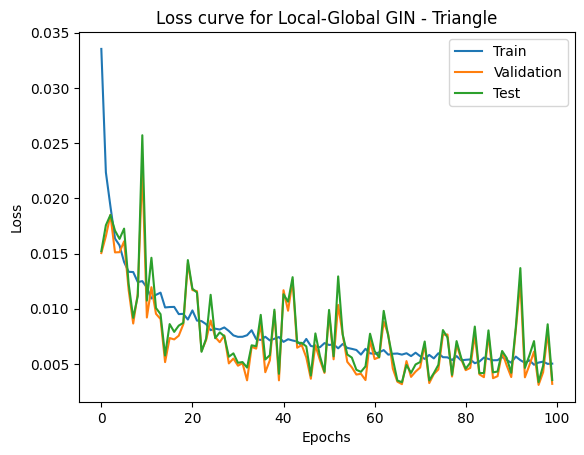

In [79]:
plt.plot(train_curve, label='Train')
plt.plot(valid_curve, label='Validation')   
plt.plot(test_curve, label='Test')
plt.legend()
plt.title('Loss curve for Local-Global GIN - Triangle')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

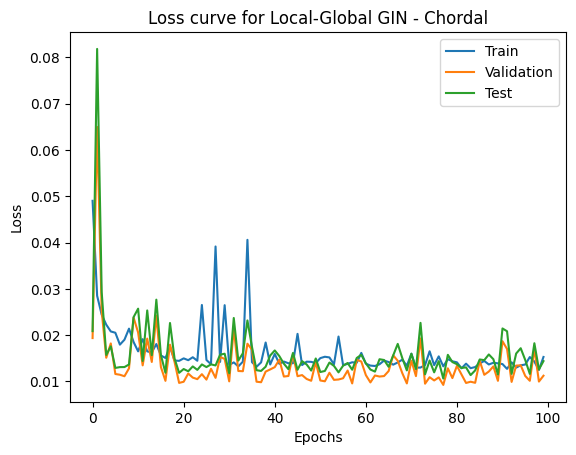

In [150]:
plt.plot(train_curve, label='Train')
plt.plot(valid_curve, label='Validation')   
plt.plot(test_curve, label='Test')
plt.legend()
plt.title('Loss curve for Local-Global GIN - Chordal')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [11]:
import torch
edges = torch.tensor([[5, 5, 5, 5, 5, 9, 9, 9, 9, 6, 6, 6, 6, 1, 1, 1, 1, 3, 3, 4, 4, 4, 4, 7,
         7, 7, 7, 7, 8, 8, 8, 0, 0, 0, 0, 0, 2, 2, 2, 2],
        [6, 2, 1, 4, 0, 8, 3, 7, 0, 5, 1, 7, 2, 5, 6, 3, 7, 9, 1, 5, 7, 8, 2, 9,
         6, 1, 4, 0, 9, 4, 0, 5, 9, 7, 8, 2, 5, 6, 4, 0]], dtype=torch.long)

from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

G = Data(edge_index=edges)
#convert to networkx graph

M = to_networkx(G)


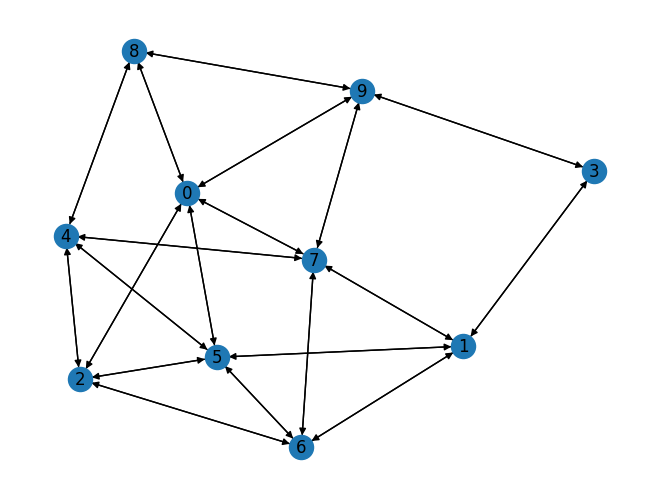

In [12]:
#plot the graph
nx.draw(M, with_labels=True)

In [206]:
edge_index = torch.tensor([[6, 7, 2, 0, 0, 0, 0, 0, 1, 3,5],
        [0, 0, 0, 6, 7, 2, 3, 1, 0, 0, 6]], dtype=torch.long)
node_dict = {0: 2, 1: 1, 2: 1, 3: 1, 6: 2, 7: 2}
ind = torch.tensor(0, dtype=torch.long)

In [208]:
edge_index_ = edge_index.T
new_edge_index = torch.tensor([], dtype=torch.long)
blablabla = torch.tensor([], dtype=torch.long)
for edge in edge_index_:
    if edge[0] == ind and node_dict[edge[1].item()] == 1:
        blablabla = torch.cat((blablabla, edge.unsqueeze(0)), dim=0)
    elif edge[1] == ind and node_dict[edge[0].item()] == 1:
        blablabla = torch.cat((blablabla, edge.unsqueeze(0)), dim=0)
blablabla.T

tensor([[2, 0, 0, 0, 1, 3],
        [0, 2, 3, 1, 0, 0]])

In [207]:
mask1 = (edge_index.T == ind.item()).all(dim=1)
mask1

tensor([False, False, False, False, False, False, False, False, False, False,
        False])